<a href="https://colab.research.google.com/github/amylynnn/weatherwise-Amylynn-Sophie/blob/main/draft%20Copy_of_Untitled18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

☁️ Welcome to the Weather Assistant ☁️

🌈 Main Menu:
1. Ask Weather Question
2. Visualize Weather Data
3. Exit
🌧️ Expect no rain in 2 today.

🌈 Main Menu:
1. Ask Weather Question
2. Visualize Weather Data
3. Exit

📊 Visualization Options:
1. Temperature
2. Precipitation
3. Back


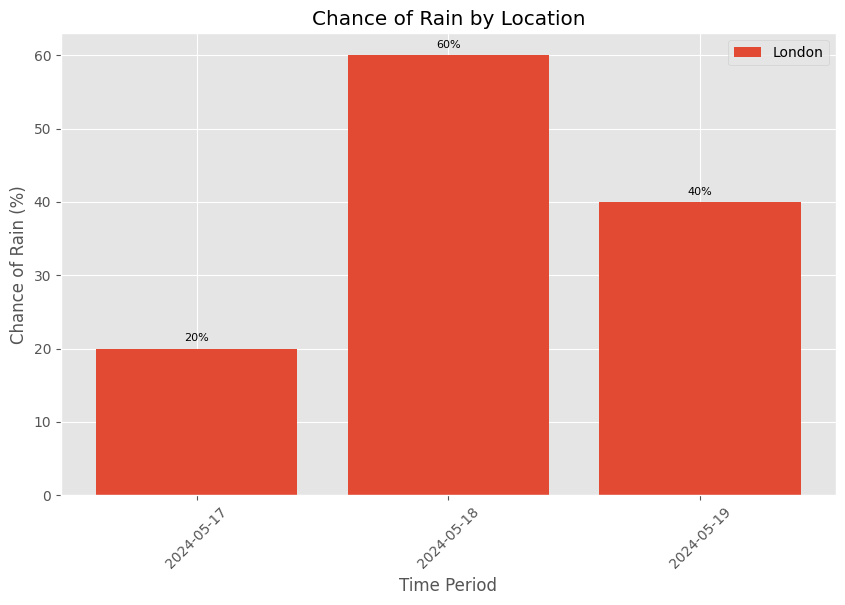


🌈 Main Menu:
1. Ask Weather Question
2. Visualize Weather Data
3. Exit


In [ ]:
# --- Notebook Setup ---
%matplotlib inline
!pip install -q matplotlib seaborn plotly pandas requests

import os
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd
from typing import Union, List, Dict

# --- 1. Weather Data Function (Mocked) ---
def get_weather(location):
    class WeatherResponse:
        def dict(self):
            return {
                "current_conditions": {"temperature": 22, "humidity": 60},
                "forecast": {
                    "today": {
                        "temperature": 22,
                        "rain": False,
                        "snow": False,
                        "wind": 15,
                        "humidity": 60
                    },
                    "tomorrow": {
                        "temperature": 25,
                        "rain": True,
                        "snow": False,
                        "wind": 18,
                        "humidity": 70
                    }
                }
            }
    return WeatherResponse()

def get_weather_data(location: Union[str, List[str]], forecast_days: int = 5) -> Dict[str, dict]:
    if isinstance(location, str):
        location = [location]
    results = {}
    for loc in location:
        try:
            weather_response = get_weather(loc)
            if not hasattr(weather_response, 'dict'):
                raise TypeError("Weather object does not support dict() conversion.")
            weather_data = weather_response.dict()
            forecast = weather_data.get("forecast", {})
            current = weather_data.get("current_conditions", {})
            if not forecast:
                raise ValueError("Forecast data is missing or empty.")
            results[loc] = {
                "current_conditions": current or "No current data available",
                "forecast": forecast
            }
        except Exception as e:
            results[loc] = {"error": f"Failed to retrieve weather for {loc}: {e}"}
    return results

# --- 2. Visualisations ---
def create_temperature_visualisation_interactive(weather_data):
    rows = []
    for location, times_data in weather_data.items():
        for time, info in times_data.items():
            rows.append({
                "Location": location,
                "Time": time,
                "Temperature": info["temperature"]
            })
    df = pd.DataFrame(rows)
    fig = px.line(df, x="Time", y="Temperature", color="Location",
                  markers=True, title="Interactive Temperature Forecast",
                  labels={"Temperature": "Temp (°C)", "Time": "Time Period"})
    fig.update_traces(mode='lines+markers', hovertemplate="%{y}°C at %{x}<br>%{fullData.name}")
    fig.update_layout(xaxis_tickangle=-45)
    fig.show()

def create_precipitation_visualisation_from_df(df: pd.DataFrame):
    plt.style.use('ggplot')
    fig, ax = plt.subplots(figsize=(10, 6))
    locations = df['Location'].unique()
    time_labels = df['Time'].unique()
    width = 0.8 / len(locations)
    x = range(len(time_labels))
    for idx, loc in enumerate(locations):
        loc_data = df[df['Location'] == loc]
        loc_data = loc_data.set_index('Time').reindex(time_labels).reset_index()
        offsets = [i + (idx * width) for i in x]
        precip = loc_data['Precipitation'].fillna(0).tolist()
        ax.bar(offsets, precip, width=width, label=loc)
        for i, value in enumerate(precip):
            ax.text(offsets[i], value + 1, f"{value}%", ha='center', fontsize=8)
    ax.set(title="Chance of Rain by Location", xlabel="Time Period", ylabel="Chance of Rain (%)")
    ax.set_xticks([i + width * (len(locations)-1)/2 for i in x])
    ax.set_xticklabels(time_labels, rotation=45)
    ax.legend()
    ax.grid(True)
    plt.show()

# --- 3. Response Generator ---
def convert_temperature(value, unit):
    if unit == "Fahrenheit":
        return round((value * 9/5) + 32)
    return value

def convert_wind_speed(value, unit):
    if unit == "mph":
        return round(value / 1.609)
    return value

def generate_weather_response(parsed, data, temp_unit='Celsius', wind_unit='km/h'):
    loc = parsed['location']
    time = parsed['time_period']
    attr = parsed['attribute']
    if loc not in data or time not in data[loc]['forecast']:
        return f"❌ No forecast available for {loc} {time}."
    forecast = data[loc]['forecast'][time]
    def convert_temp(c): return f"{convert_temperature(c, temp_unit)}°{'F' if temp_unit == 'Fahrenheit' else 'C'}"
    def convert_wind(w): return f"{convert_wind_speed(w, wind_unit)} {wind_unit}"
    responses = {
        'temperature': lambda: f"🌡️ Temperature in {loc} {time} is {convert_temp(forecast.get('temperature', 'unknown'))}.",
        'rain': lambda: f"🌧️ Expect {'rain' if forecast.get('rain') else 'no rain'} in {loc} {time}.",
        'snow': lambda: f"❄️ Expect {'snow' if forecast.get('snow') else 'no snow'} in {loc} {time}.",
        'wind': lambda: f"💨 Wind speed in {loc} {time} is {convert_wind(forecast.get('wind', 'unknown'))}.",
        'humidity': lambda: f"💧 Humidity in {loc} {time} is {forecast.get('humidity', 'unknown')}%."
    }
    if attr in responses:
        return responses[attr]()
    else:
        temp = convert_temp(forecast.get('temperature', 'unknown'))
        rain = 'rain' if forecast.get('rain') else 'no rain'
        return f"In {loc} {time}, temperature is {temp} with {rain}."

# --- 4. Simple Text-Based Menu (Colab-Friendly) ---
def run_interface():
    print("☁️ Welcome to the Weather Assistant ☁️")
    while True:
        print("\n🌈 Main Menu:\n1. Ask Weather Question\n2. Visualize Weather Data\n3. Exit")
        choice = input("Enter choice (1/2/3): ").strip()
        if choice == '1':
            location = input("Enter location (e.g., London): ").strip()
            time = input("Enter time (today/tomorrow): ").strip().lower()
            attribute = input("Enter attribute (temperature/rain/snow/wind/humidity): ").strip().lower()
            parsed = {
                "location": location,
                "time_period": time,
                "attribute": attribute
            }
            data = get_weather_data(location)
            print(generate_weather_response(parsed, data))

        elif choice == '2':
            print("\n📊 Visualization Options:\n1. Temperature\n2. Precipitation\n3. Back")
            vis_choice = input("Choose type (1/2/3): ").strip()
            if vis_choice == '1':
                sample_data = {
                    "London": {
                        "2024-05-17": {"temperature": 22},
                        "2024-05-18": {"temperature": 24},
                        "2024-05-19": {"temperature": 21}
                    }
                }
                create_temperature_visualisation_interactive(sample_data)
            elif vis_choice == '2':
                sample_df = pd.DataFrame({
                    "Location": ["London", "London", "London"],
                    "Time": ["2024-05-17", "2024-05-18", "2024-05-19"],
                    "Precipitation": [20, 60, 40]
                })
                create_precipitation_visualisation_from_df(sample_df)
            elif vis_choice == '3':
                continue
            else:
                print("Invalid input.")

        elif choice == '3':
            print("👋 Exiting Weather Assistant. Stay safe!")
            break
        else:
            print("❌ Invalid input. Please try again.")

# --- Run the App ---
run_interface()
